In [1]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score,roc_auc_score
from sklearn.metrics import f1_score,roc_curve,recall_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from pandas import get_dummies
import matplotlib as mpl
from scipy import stats
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
pd.options.display.max_rows = 100


In [2]:
#to ignore warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#cat mean table where each values of mean is calculated based on some variable value
def get_mean_table(dat, var, targ, diff = 1, drp = [], rnd = 2, freq = 0, prt_gps = 0, drp_flg = 1):
	'''
	dat: name of the dataframe
	var: feature for the dummies to be made
	targ: target on which grouping should be decided (currently by mean)
	diff: the range for grouping (eg - 0.5 will be 1-0.5, 0.5-2); default = 1
	drp: specific elements of the feature (like "nan", "Na", "other", "Unknown") to be dropped
	rnd: the no of placed to be rounded; default = 2
	freq: min count of elements to make dummies; default = 0
	prt_gps: gives group view
	'''
	data = dat[dat.columns]
	if data[var].dtypes != "object":
		data[var] = data[var].astype(str)
	tab = data[var].value_counts(ascending = False)                          #find the counts of elements
	tabInd = tab.index                                                       #get all the elements
	if drp_flg == 0:
		tab = tab[tab>=freq]                                                 #get elements which surpass freq threshold and exclude least frequent
	else:
		tab = tab[tab>=freq][:-1] 
	tab_drp = tab.index
	tab_drp = list(tabInd[np.logical_not(tabInd.isin(tab_drp))])            #get all the elements which doest qualify freq threshold
	tab_drp.extend(drp)                                                     #concat all the usr specified drp elements
	if len(tab_drp) > 0:
		data[var] = np.where(data[var].isin(tab_drp),"drp@567",data[var])   #replace all the drop elements with drp@123
		newtab = (data[[var,targ]].groupby(var)[targ].mean().round(rnd).drop(["drp@567"]).sort_values()) #get a crosstab of var and targ with mean; drp all the replaced elements
	else: 
		newtab = (data[[var,targ]].groupby(var)[targ].mean().round(rnd).sort_values())
	newtab_rtn = newtab

	intro_text = "Visual"
	intro_text = intro_text+" grouped tables" if prt_gps == 1 else intro_text+" table"
	intro_text = intro_text+" with drop for " if drp_flg == 1 else intro_text+" without drop for "
	print("\n\n--------------------\n--------------------\n",intro_text,var,sep="")
	if prt_gps != 0:
		cnt = 0
		while(not newtab.empty):                                         #cut the loop as soon as mean table is empty
			least = newtab[0]                                            #current min value of the mean table
			upper_bond = least+diff                                      #get the upper bound by adding the use specified difference
			smol_tab = newtab[np.logical_and(newtab.values>=least, newtab <upper_bond)] #get the elements of specified range
			smol_tab = pd.merge(left=smol_tab,right=tab,right_index=True,left_index=True,how="left")
			smol_tab.columns=["mean","count"]
			print(smol_tab)
			print("Total count =  ", sum(smol_tab["count"]), end="\n-----------\n\n")
			newtab=newtab.drop(smol_tab.index)
			cnt = cnt+1
		print("no of new groups", cnt, end="\n-----------\n\n")

	newtab_rtn = pd.merge(left=newtab_rtn,right=tab,right_index=True,left_index=True,how="left")
	newtab_rtn.columns=["mean","count"]
	no_rcs_cvd, ttl_rcd = sum(newtab_rtn["count"]),data.shape[0]
	rcs_pcd = round((no_rcs_cvd/ttl_rcd)*100,2)
	print("no of records covered =",no_rcs_cvd,"out of",ttl_rcd, "i.e.",rcs_pcd)
	print("no of rows: ",newtab_rtn.shape[0])
	return(newtab_rtn)

In [4]:
#creating dummies
def getting_dummies(dat,var,freq = 0, drp_flg = False, drp = []):
	data= dat[dat.columns]
	tab = data[var].value_counts(ascending = False)
	tab = tab.index[tab>=freq][:-1].tolist() if drp_flg else tab.index[tab>=freq].tolist()
	for i in drp: tab.remove(i)
	print("\n\n--------------------\n--------------------\nDummies for",var)
	print("no of new columns from",var,"is",len(tab))
	print(tab)
	to_return_df = pd.DataFrame({"delthis":np.arange(data.shape[0])})#new dummies dataframe
	for i in tab:
		j = str(i)
		j = j.replace(" ","_")
		namee = var+"_"+j
		to_return_df[namee]=(data[var]==i).astype(int)
	to_return_df.drop(["delthis"],axis=1,inplace=True)
	return to_return_df

In [5]:
#generating report for tuning
def my_random_forest_report(cv_results, n_top=3):
    '''
    cv_results: Takes the randomForest_object.cv_results_
    n_top: No of top results to be displayed
    
    Description:
        randomForest_object.cv_results_ gives a long list of attributes.
        This report function retuns only the top n from results from that big list in a graspable format.
    '''
    for i in range(1,n_top+1,1):
        rank_indices = np.flatnonzero(cv_results["rank_test_score"]==i)
        # the following loop is made because there can be one or more elements of the same rank
        for rank_index in rank_indices:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                cv_results["mean_test_score"][rank_index],
                cv_results["std_test_score"][rank_index]))
            print("Parameters: {0}".format(cv_results["params"][rank_index]))
            print("")

In [6]:
#function for filling the mort_acc with total_acc and calculate the mean value for the mort_acc per total_acc entry
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return bins[total_acc].round()
    else:
        return mort_acc

In [7]:
#loading the dataset
dataIn = pd.read_csv("lending_club_loan_two.csv",parse_dates=['issue_d'],infer_datetime_format = True,low_memory=False)
dataIn.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [8]:
#copying data
data = pd.DataFrame.copy(dataIn)

In [9]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [10]:
data.shape

(396030, 27)

In [11]:
#count of the y variable
data["loan_status"].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

In [12]:
#replacing the categorical variable with 0 and 1
data["loan_status"] = data['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

<AxesSubplot:xlabel='loan_status', ylabel='count'>

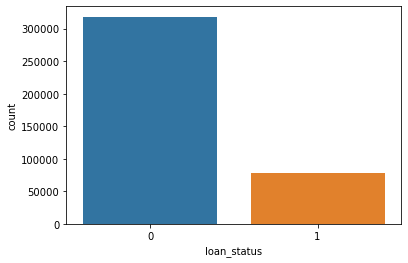

In [13]:
#visualize the loan_status for EDA
sns.countplot(data.loan_status)

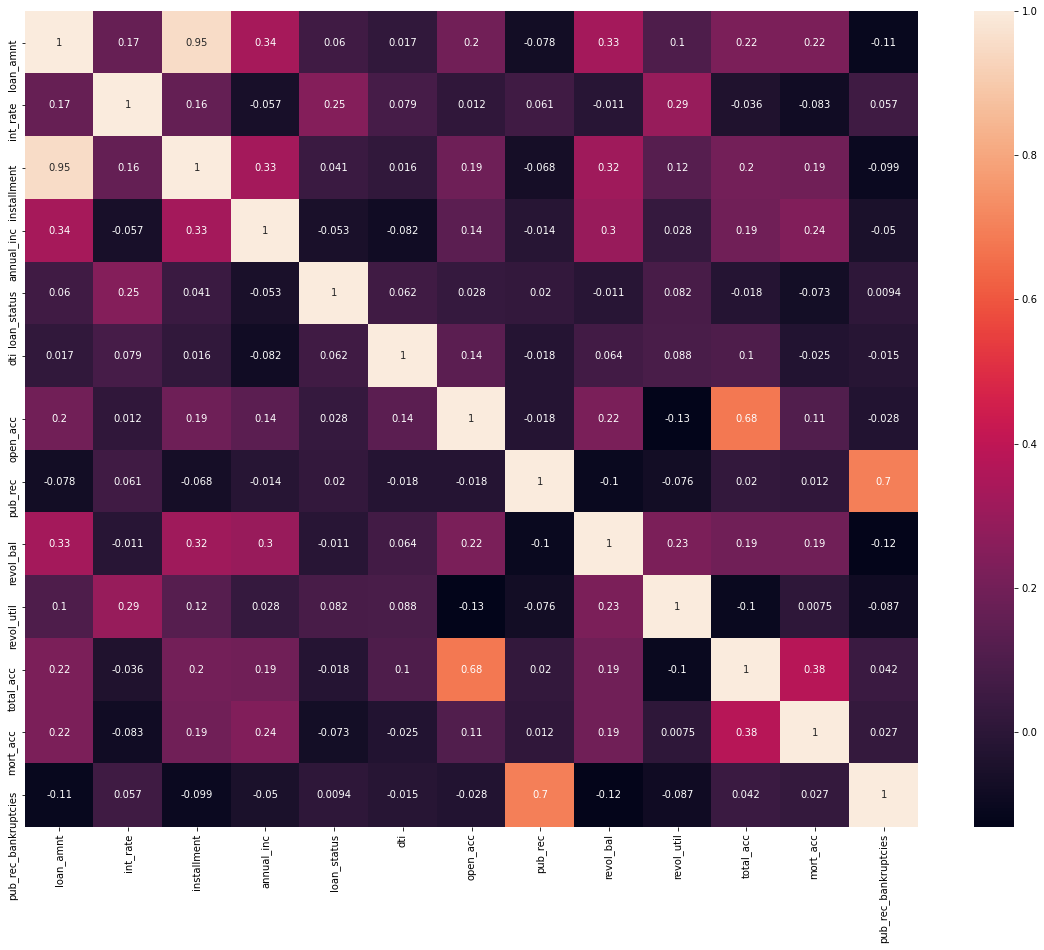

In [14]:
#finding the correlation
data_corrl=data.corr()
#ploting the heatmap for finding the co relation
f,ax=plt.subplots(figsize=(20,15))
sns.heatmap(data_corrl, xticklabels=data_corrl.columns.values,yticklabels=data_corrl.columns.values,annot=True)
plt.show()


<AxesSubplot:xlabel='installment', ylabel='loan_amnt'>

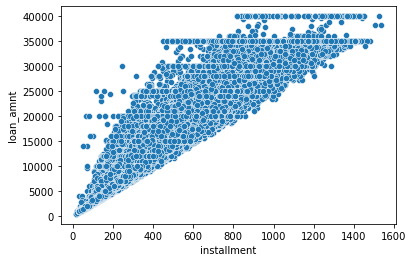

In [15]:
#installment and loan_amnt have perfect co relation
#using scatter plot to see the corelation between installment and loan_amount
sns.scatterplot(x='installment', y='loan_amnt', data=data)

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

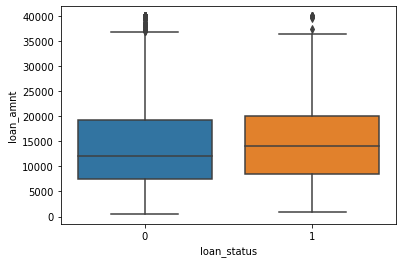

In [16]:
#comparing loan_amount with y varibale using boxplot
sns.boxplot(x='loan_status', y='loan_amnt', data=data)

In [17]:
#exploring the grade 
data.grade.unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [18]:
#exploring the grade 
data.sub_grade.unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

<AxesSubplot:xlabel='grade', ylabel='count'>

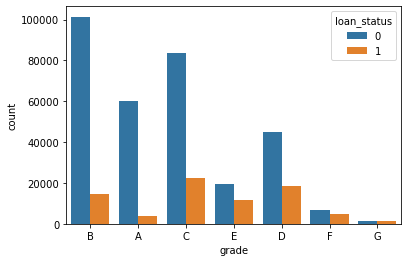

In [19]:
#seeing counts of grade and loan_status using histogram
sns.countplot(x='grade', data=data, hue='loan_status')

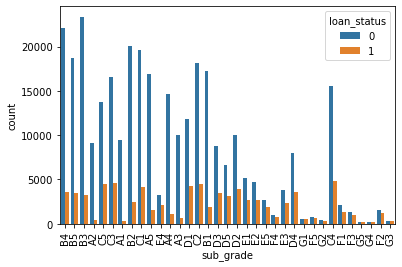

In [20]:
#seeing counts of sub_grade and loan_status using histogram
sgrade = sns.countplot(x='sub_grade', data=data, hue='loan_status')
sgrade.set_xticklabels(sgrade.get_xticklabels(), rotation=90);

In [21]:
#grade and subgrade F and G have no significant contribution on loan_status hence we can ignore them

In [22]:
#purpose count 
data.purpose.value_counts()

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

In [23]:
#mering the values that are less than a threshold 10000
cond = data['purpose'].value_counts()
threshold = 10000
data['purpose'] = np.where(data['purpose'].isin(cond.index[cond >= threshold ]), data['purpose'], 'miscellaneous')

In [24]:
#reverifying the purpose var
data.purpose.value_counts()

debt_consolidation    234507
credit_card            83019
miscellaneous          33289
home_improvement       24030
other                  21185
Name: purpose, dtype: int64

In [25]:
#count for home_ownership
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [26]:
#mering the values that are less than a threshold 10000
cond = data['home_ownership'].value_counts()
threshold = 10000
data['home_ownership'] = np.where(data['home_ownership'].isin(cond.index[cond >= threshold ]), data['home_ownership'], 'others')


In [27]:
#reverifying the purpose var
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
others         146
Name: home_ownership, dtype: int64

In [28]:
#count for term
data.term.value_counts()

 36 months    302005
 60 months     94025
Name: term, dtype: int64

In [29]:
#count for verification_status
data.verification_status.value_counts()

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64

In [30]:
#count for emp_title
data.emp_title.value_counts()

Teacher                       4389
Manager                       4250
Registered Nurse              1856
RN                            1846
Supervisor                    1830
                              ... 
K&K Technical Group              1
Island City Flying Service       1
Engr tech                        1
Planview Inc                     1
Enterprise Strategy Group        1
Name: emp_title, Length: 173105, dtype: int64

In [31]:
#count for emp_length
data.emp_length.value_counts(dropna=False)

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: emp_length, dtype: int64

In [32]:
#seeing the title
data.title.value_counts()

Debt consolidation                     152472
Credit card refinancing                 51487
Home improvement                        15264
Other                                   12930
Debt Consolidation                      11608
                                        ...  
New bathroom, new kitchen!                  1
Pay off Citicard                            1
First consolidation                         1
Consolidation of high interest debt         1
dept fix                                    1
Name: title, Length: 48817, dtype: int64

In [33]:
#title coulmn can be removed because purpose col has the same meaning as title

<AxesSubplot:>

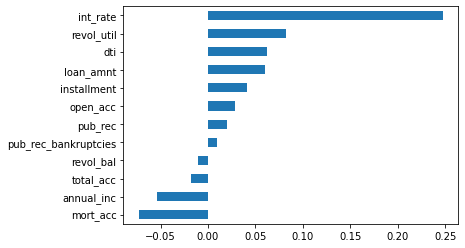

In [34]:
#seeing the corelation between the loan_status and other variables
data.corr()['loan_status'].drop('loan_status').sort_values().plot(kind='barh')

In [35]:
#data preprocessing
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [36]:
#for emp_length
data.emp_length.value_counts(dropna=False)

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: emp_length, dtype: int64

In [37]:
#replacing the emp_length values with their numbers
data["emp_length"] = data['emp_length'].replace({'2 years': 2, '1 year': 1, '4 years': 4, '8 years': 8,
                                                                 '10+ years': 10, '9 years': 9.0, '< 1 year': 0, '6 years': 6,
                                                                 '7 years': 7, '3 years': 3, '5 years': 5})

In [38]:
#filling missing values with 11 to see the counts of missing value
data.emp_length=data.emp_length.fillna(11)

In [39]:
data.emp_length.value_counts()

10.0    126041
2.0      35827
0.0      31725
3.0      31665
5.0      26495
1.0      25882
4.0      23952
6.0      20841
7.0      20819
8.0      19168
11.0     18301
9.0      15314
Name: emp_length, dtype: int64

In [40]:
#getting the mean value of emp_length with loan_status to impute missing vale '11'
get_mean_table(data, "emp_length", "loan_status", 0.01, rnd = 3, freq= 0, drp_flg = 0)



--------------------
--------------------
Visual table without drop for emp_length
no of records covered = 396030 out of 396030 i.e. 100.0
no of rows:  12


,mean,count
emp_length,,
10.0,0.184,126041
6.0,0.189,20841
4.0,0.192,23952
5.0,0.192,26495
2.0,0.193,35827
3.0,0.195,31665
7.0,0.195,20819
1.0,0.199,25882
8.0,0.200,19168


In [41]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

<AxesSubplot:>

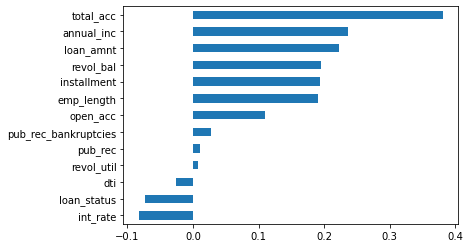

In [42]:
#to fill mort_acc we are comparing it with other variables to see the corelation
data.corr()['mort_acc'].drop('mort_acc').sort_values().plot(kind='barh')

In [43]:
#this shows that total_acc and mort_acc are correalted


In [44]:
#making bins of total accounts
bins = data.groupby(by='total_acc').mean().mort_acc
bins

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

In [45]:
#filling the mort_acc with help of total_acc and calculate the mean value for the mort_acc per total_acc entry
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [46]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                    0
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [47]:
#converting the address variable into zipcode because address variable has char values
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [48]:
data.zip_code.value_counts()

70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: zip_code, dtype: int64

In [49]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [50]:
#removing the address var
data.drop('address', axis=1, inplace=True)

In [51]:
data.dtypes

loan_amnt                      float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                      int64
purpose                         object
title                           object
dti                            float64
earliest_cr_line                object
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status             object
application_type                object
mort_acc                       float64
pub_rec_bankruptcies     

In [52]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    

10.0 years in this position:
0    0.815814
1    0.184186
Name: loan_status, dtype: float64
4.0 years in this position:
0    0.807615
1    0.192385
Name: loan_status, dtype: float64
0.0 years in this position:
0    0.793128
1    0.206872
Name: loan_status, dtype: float64
6.0 years in this position:
0    0.810806
1    0.189194
Name: loan_status, dtype: float64
9.0 years in this position:
0    0.79953
1    0.20047
Name: loan_status, dtype: float64
2.0 years in this position:
0    0.806738
1    0.193262
Name: loan_status, dtype: float64
3.0 years in this position:
0    0.804769
1    0.195231
Name: loan_status, dtype: float64
8.0 years in this position:
0    0.80024
1    0.19976
Name: loan_status, dtype: float64
7.0 years in this position:
0    0.805226
1    0.194774
Name: loan_status, dtype: float64
5.0 years in this position:
0    0.807813
1    0.192187
Name: loan_status, dtype: float64
1.0 years in this position:
0    0.800865
1    0.199135
Name: loan_status, dtype: float64
11.0 years in

In [53]:
#deleting title as it is sub part of purpose
del data['title']

In [54]:
#Charge off rates are extremely similar across all employment lengths. So we are going to drop the emp_length column.

In [55]:
del data['emp_length']

In [56]:
#because emp_title has too many distinct values hence dummies cannot be created
del data['emp_title']

In [57]:
#dropping the grade var as it is sub feature of sub_grade
del data['grade']

In [58]:
#finding the percentage of missing values 
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

In [59]:
missing_value_df

,column_name,percent_missing
loan_amnt,loan_amnt,0.000000
term,term,0.000000
int_rate,int_rate,0.000000
installment,installment,0.000000
sub_grade,sub_grade,0.000000
home_ownership,home_ownership,0.000000
annual_inc,annual_inc,0.000000
verification_status,verification_status,0.000000
issue_d,issue_d,0.000000
loan_status,loan_status,0.000000


In [60]:
#it is clear that revol_util and pub_rec_bankruptcies has mininmum missing values thus droping the missing values

In [61]:
data.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
zip_code_05113            0
zip_code_11650            0
zip_code_22690            0
zip_code_29597            0
zip_code_30723            0
zip_code_48052            0
zip_code_70466            0
zip_code_86630            0
zip_code_93700            0
dtype: int64

In [62]:
data.dropna(inplace=True)

In [63]:
#creating dummy variables of cat var

In [64]:
data.dtypes

loan_amnt                      float64
term                            object
int_rate                       float64
installment                    float64
sub_grade                       object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                      int64
purpose                         object
dti                            float64
earliest_cr_line                object
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status             object
application_type                object
mort_acc                       float64
pub_rec_bankruptcies           float64
zip_code_05113                   uint8
zip_code_11650                   uint8
zip_code_22690                   uint8
zip_code_29597           

In [65]:
#creating dummy variables for cat var

In [66]:
#converting term obj to numeric
data["term"] = data['term'].replace({' 36 months': 0, ' 60 months': 1})

In [67]:
data.initial_list_status.unique()

array(['w', 'f'], dtype=object)

In [68]:
data.initial_list_status.value_counts()

f    237346
w    157873
Name: initial_list_status, dtype: int64

In [69]:
#converting initial_list_status obj to numeric
data["initial_list_status"] = data['initial_list_status'].replace({'f': 0, 'w': 1})

In [70]:
#label encoding is done in alphabetical order so doing encoding for sub_grade
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le1.fit(data['sub_grade'])
this_class = le1.classes_
data['sub_grade'] = le1.transform(data['sub_grade'])
data.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,pub_rec_bankruptcies,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,0,11.44,329.48,8,RENT,117000.0,Not Verified,2015-01-01,0,...,0.0,0,0,1,0,0,0,0,0,0
1,8000.0,0,11.99,265.68,9,MORTGAGE,65000.0,Not Verified,2015-01-01,0,...,0.0,1,0,0,0,0,0,0,0,0
2,15600.0,0,10.49,506.97,7,RENT,43057.0,Source Verified,2015-01-01,0,...,0.0,1,0,0,0,0,0,0,0,0
3,7200.0,0,6.49,220.65,1,RENT,54000.0,Not Verified,2014-11-01,0,...,0.0,0,0,0,0,0,0,0,0,0
4,24375.0,1,17.27,609.33,14,MORTGAGE,55000.0,Verified,2013-04-01,1,...,0.0,0,1,0,0,0,0,0,0,0


In [71]:
#cdummies for purpose
data["purpose"].value_counts(dropna=False)

for i in ['credit_card','home_improvement','other', 'debt_consolidation']:
    drop = ['credit_card','home_improvement','miscellaneous','other', 'debt_consolidation']
    drop.remove(i)
    name = "purpose" + i
    data[name] = getting_dummies(data,'purpose',freq = 0, drp_flg = False, drp = drop)
    data[name] = data[name].fillna(0)



--------------------
--------------------
Dummies for purpose
no of new columns from purpose is 1
['credit_card']


--------------------
--------------------
Dummies for purpose
no of new columns from purpose is 1
['home_improvement']


--------------------
--------------------
Dummies for purpose
no of new columns from purpose is 1
['other']


--------------------
--------------------
Dummies for purpose
no of new columns from purpose is 1
['debt_consolidation']


In [72]:
for i in ['MORTGAGE', 'RENT','OWN']:
    drop = ['MORTGAGE', 'RENT','OWN','others']
    drop.remove(i)
    name = "home_ownership_" + i
    data[name] = getting_dummies(data,'home_ownership',freq = 0, drp_flg = False, drp = drop)
    data[name] = data[name].fillna(0)



--------------------
--------------------
Dummies for home_ownership
no of new columns from home_ownership is 1
['MORTGAGE']


--------------------
--------------------
Dummies for home_ownership
no of new columns from home_ownership is 1
['RENT']


--------------------
--------------------
Dummies for home_ownership
no of new columns from home_ownership is 1
['OWN']


In [73]:
data["verification_status"] = data['verification_status'].replace({'Source Verified': 1, 'Verified': 1, 'Not Verified': 0})

In [74]:
data["application_type"] = data["application_type"].replace({'JOINT': 0, 'INDIVIDUAL': 1,'DIRECT_PAY': 2})

In [75]:
data = pd.get_dummies(data, columns=['application_type'], drop_first=True)

In [76]:
data = pd.get_dummies(data, columns=['sub_grade'], drop_first=True)

In [77]:
data = pd.get_dummies(data, columns=['verification_status'], drop_first=True)

In [78]:
data = pd.get_dummies(data, columns=['initial_list_status'], drop_first=True)

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data.dtypes

In [ ]:
data.isnull().sum()

In [79]:
for i in ['home_ownership','purpose']:
    del data[i]

In [80]:
#converting earliest_cr_line to numeric
data['earliest_cr_line'] = data.earliest_cr_line.str.split('-', expand=True)[1]

In [81]:
#dividing data into equal no of 0 and 1
dataforsep = data[data.loan_status==0]

In [82]:
# three dataframes from undersampling
sz = dataforsep.shape[0] - data[data.loan_status==1].shape[0]

drp_id = np.random.choice(dataforsep.index, size = sz, replace = False)
data1 = data.drop(drp_id, axis = 0)
data1 = data1.reset_index(drop = True)

drp_id = np.random.choice(dataforsep.index, size = sz, replace = False)
data2 = data.drop(drp_id, axis = 0)
data2 = data2.reset_index(drop = True)

drp_id = np.random.choice(dataforsep.index, size = sz, replace = False)
data3 = data.drop(drp_id, axis = 0)
data3 = data3.reset_index(drop = True)

In [83]:
#removing isuess date
data1 = data1.drop(["issue_d"], axis = 1)
data2 = data2.drop(["issue_d"], axis = 1)
data3 = data3.drop(["issue_d"], axis = 1)
data1 = data1.drop(["earliest_cr_line"], axis = 1)
data2 = data2.drop(["earliest_cr_line"], axis = 1)
data3 = data3.drop(["earliest_cr_line"], axis = 1)




In [84]:
data1_x, data1_y = data1.drop("loan_status",axis = 1), data1['loan_status']
data2_x, data2_y = data2.drop("loan_status",axis = 1), data2['loan_status']
data3_x, data3_y = data3.drop("loan_status",axis = 1), data3['loan_status']

In [85]:
data1_train_x, data1_test_x, data1_train_y, data1_test_y = train_test_split(data1_x, data1_y, test_size=0.3, random_state=42, stratify=data1_y)
data1_train_x, data1_test_x, data1_train_y, data1_test_y = data1_train_x.reset_index(drop = True), data1_test_x.reset_index(drop = True), data1_train_y, data1_test_y.reset_index(drop = True)

data2_train_x, data2_test_x, data2_train_y, data2_test_y = train_test_split(data2_x, data2_y, test_size=0.3, random_state=42, stratify=data2_y)
data2_train_x, data2_test_x, data2_train_y, data2_test_y = data2_train_x.reset_index(drop = True), data2_test_x.reset_index(drop = True), data2_train_y, data2_test_y.reset_index(drop = True)

data3_train_x, data3_test_x, data3_train_y, data3_test_y = train_test_split(data3_x, data3_y, test_size=0.3, random_state=42, stratify=data3_y)
data3_train_x, data3_test_x, data3_train_y, data3_test_y = data3_train_x.reset_index(drop = True), data3_test_x.reset_index(drop = True), data3_train_y, data3_test_y.reset_index(drop = True)

In [88]:
#keeping columns for standardizition 
data1_train_x.columns
cols = ['loan_amnt', 'installment','int_rate', 'annual_inc',
        'dti', 
         'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'total_acc','mort_acc' ,'pub_rec_bankruptcies']


In [89]:
sc = StandardScaler()
sc.fit(data1_train_x[cols])
temp_train = pd.DataFrame(sc.transform(X = data1_train_x[cols]), columns = cols)
temp_test = pd.DataFrame(sc.transform(X = data1_test_x[cols]), columns = cols)
data1_train_x.drop(cols, axis = 1, inplace = True)
data1_test_x.drop(cols, axis = 1, inplace = True)
data1_train_x = pd.concat([data1_train_x, temp_train], axis = 1)
data1_test_x = pd.concat([data1_test_x, temp_test], axis = 1)



In [90]:
#keeping columns for standardizition 
data1_train_x.columns
cols = ['loan_amnt', 'installment','int_rate', 'annual_inc',
        'dti', 
         'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'total_acc','mort_acc' ,'pub_rec_bankruptcies']


In [91]:
sc = StandardScaler()
sc.fit(data1_train_x[cols])
temp_train = pd.DataFrame(sc.transform(X = data1_train_x[cols]), columns = cols)
temp_test = pd.DataFrame(sc.transform(X = data1_test_x[cols]), columns = cols)
data1_train_x.drop(cols, axis = 1, inplace = True)
data1_test_x.drop(cols, axis = 1, inplace = True)
data1_train_x = pd.concat([data1_train_x, temp_train], axis = 1)
data1_test_x = pd.concat([data1_test_x, temp_test], axis = 1)



In [92]:
#keeping columns for standardizition 
data1_train_x.columns
cols = ['loan_amnt', 'installment','int_rate', 'annual_inc',
        'dti', 
         'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'total_acc','mort_acc' ,'pub_rec_bankruptcies']


In [93]:
sc = StandardScaler()
sc.fit(data1_train_x[cols])
temp_train = pd.DataFrame(sc.transform(X = data1_train_x[cols]), columns = cols)
temp_test = pd.DataFrame(sc.transform(X = data1_test_x[cols]), columns = cols)
data1_train_x.drop(cols, axis = 1, inplace = True)
data1_test_x.drop(cols, axis = 1, inplace = True)
data1_train_x = pd.concat([data1_train_x, temp_train], axis = 1)
data1_test_x = pd.concat([data1_test_x, temp_test], axis = 1)



In [94]:
#logistic regression
logisticmodel1= LogisticRegression()
logisticmodel1.fit(data1_train_x,data1_train_y)
Y_pred=logisticmodel1.predict(data1_test_x);

In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data1_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data1_test_y,Y_pred));
acc = accuracy_score(data1_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[18561  4696]
 [ 4392 18865]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     23257
           1       0.80      0.81      0.81     23257

    accuracy                           0.80     46514
   macro avg       0.80      0.80      0.80     46514
weighted avg       0.80      0.80      0.80     46514

Accuracy of the model :  0.8046179644838113


In [96]:
#logistic regression
logisticmodel1= LogisticRegression()
logisticmodel1.fit(data2_train_x,data2_train_y)
Y_pred=logisticmodel1.predict(data2_test_x);

In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data2_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data2_test_y,Y_pred));
acc = accuracy_score(data2_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[11056 12201]
 [ 6743 16514]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.62      0.48      0.54     23257
           1       0.58      0.71      0.64     23257

    accuracy                           0.59     46514
   macro avg       0.60      0.59      0.59     46514
weighted avg       0.60      0.59      0.59     46514

Accuracy of the model :  0.5927247710366771


In [98]:
#logistic regression
logisticmodel1= LogisticRegression()
logisticmodel1.fit(data3_train_x,data3_train_y)
Y_pred=logisticmodel1.predict(data3_test_x);

In [99]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data3_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data3_test_y,Y_pred));
acc = accuracy_score(data3_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[12213 11044]
 [ 7080 16177]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.63      0.53      0.57     23257
           1       0.59      0.70      0.64     23257

    accuracy                           0.61     46514
   macro avg       0.61      0.61      0.61     46514
weighted avg       0.61      0.61      0.61     46514

Accuracy of the model :  0.6103538719525304


In [110]:
#xgboost
rf= XGBClassifier()
rf.fit(data1_train_x,data1_train_y)
Y_pred=rf.predict(data1_test_x);

[22:51:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data1_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data1_test_y,Y_pred));
acc = accuracy_score(data1_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[18676  4581]
 [ 4498 18759]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     23257
           1       0.80      0.81      0.81     23257

    accuracy                           0.80     46514
   macro avg       0.80      0.80      0.80     46514
weighted avg       0.80      0.80      0.80     46514

Accuracy of the model :  0.8048114546158146


In [112]:
#xgboost
rf= XGBClassifier()
rf.fit(data2_train_x,data2_train_y)
Y_pred=rf.predict(data2_test_x);

[22:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [113]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data2_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data2_test_y,Y_pred));
acc = accuracy_score(data2_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[18532  4725]
 [ 4341 18916]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     23257
           1       0.80      0.81      0.81     23257

    accuracy                           0.81     46514
   macro avg       0.81      0.81      0.81     46514
weighted avg       0.81      0.81      0.81     46514

Accuracy of the model :  0.8050909403620415


In [114]:
#xgboost
rf= XGBClassifier()
rf.fit(data3_train_x,data3_train_y)
Y_pred=rf.predict(data2_test_x);

[22:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data3_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data3_test_y,Y_pred));
acc = accuracy_score(data3_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[18761  4496]
 [ 4433 18824]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     23257
           1       0.81      0.81      0.81     23257

    accuracy                           0.81     46514
   macro avg       0.81      0.81      0.81     46514
weighted avg       0.81      0.81      0.81     46514

Accuracy of the model :  0.8080362901492024


In [101]:
#random forest
rdf= RandomForestClassifier()
rdf.fit(data1_train_x,data1_train_y)
Y_pred=rdf.predict(data1_test_x);

In [102]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data1_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data1_test_y,Y_pred));
acc = accuracy_score(data1_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[19223  4034]
 [ 5515 17742]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     23257
           1       0.81      0.76      0.79     23257

    accuracy                           0.79     46514
   macro avg       0.80      0.79      0.79     46514
weighted avg       0.80      0.79      0.79     46514

Accuracy of the model :  0.7947069699445328


In [104]:
#random forest
rdf= RandomForestClassifier()
rdf.fit(data2_train_x,data2_train_y)
Y_pred=rdf.predict(data2_test_x);

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data2_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data2_test_y,Y_pred));
acc = accuracy_score(data2_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[19094  4163]
 [ 5394 17863]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     23257
           1       0.81      0.77      0.79     23257

    accuracy                           0.79     46514
   macro avg       0.80      0.79      0.79     46514
weighted avg       0.80      0.79      0.79     46514

Accuracy of the model :  0.7945349787160855


In [106]:
#random forest
rdf= RandomForestClassifier()
rdf.fit(data3_train_x,data3_train_y)
Y_pred=rdf.predict(data3_test_x);

In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report;
cfm = confusion_matrix(data3_test_y,Y_pred);
print(cfm);
print("Classification Report : ");
print(classification_report(data3_test_y,Y_pred));
acc = accuracy_score(data3_test_y,Y_pred);
print("Accuracy of the model : ",acc);

[[19184  4073]
 [ 5430 17827]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     23257
           1       0.81      0.77      0.79     23257

    accuracy                           0.80     46514
   macro avg       0.80      0.80      0.80     46514
weighted avg       0.80      0.80      0.80     46514

Accuracy of the model :  0.795695919508105
